# Load datas

In [749]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import vincenty

In [750]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv') # train set
df_mess_test = pd.read_csv('mess_test_list.csv') # test set
pos_train = pd.read_csv('pos_train_list.csv') # position associated to train set

# Exploratory data analysis

## Explore the two train tables

In [751]:
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [752]:
df_mess_train.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000


In [753]:
pos_train.head()

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


In [754]:
pos_train.describe()

,lat,lng
count,39250.000000,39250.000000
mean,39.783333,-105.056343
std,0.206262,0.162954
min,35.770683,-107.630679
25%,39.708599,-105.060463
50%,39.776882,-105.039440
75%,39.805279,-105.018730
max,43.140387,-102.094289


## Number of base stations

We might wonder how many base stations there are. This might give us some information on what to expect

In [755]:
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) # determine all Base stations that received at least 1 message

In [756]:
len(listOfBs)

259

## Distributions

We can now take a look at the distribution of the numerical columns of df_mess_train.

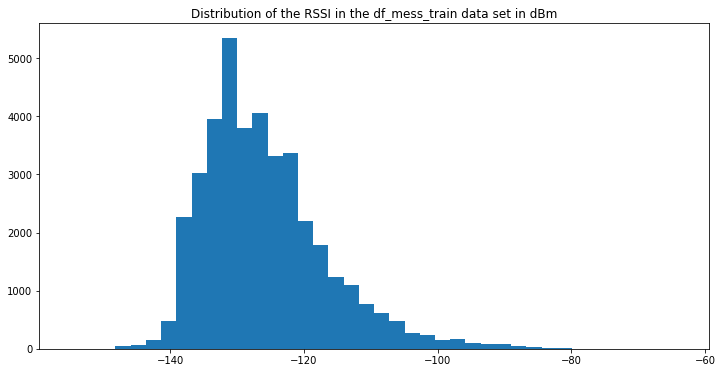

In [757]:
plt.figure(figsize=(12,6))
plt.hist(df_mess_train['rssi'], bins = 40)
plt.title('Distribution of the RSSI in the df_mess_train data set in dBm')
plt.show()

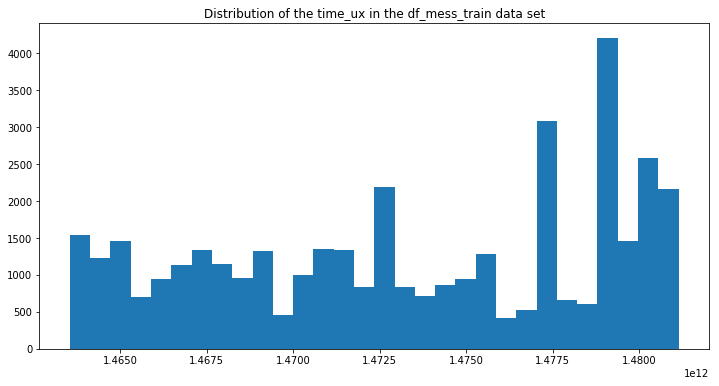

In [758]:
plt.figure(figsize=(12,6))
plt.hist(df_mess_train['time_ux'], bins = 30)
plt.title('Distribution of the time_ux in the df_mess_train data set')
plt.show()

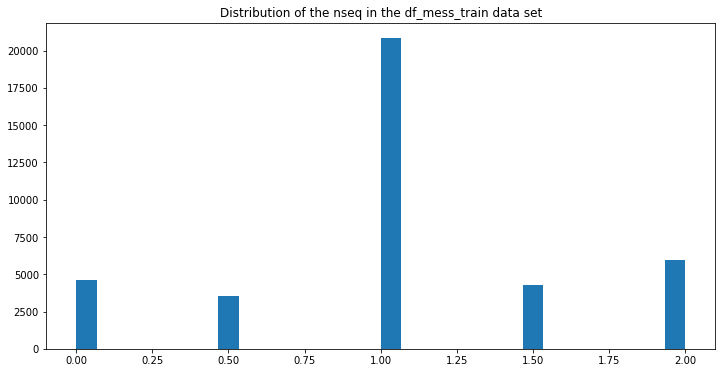

In [759]:
plt.figure(figsize=(12,6))
plt.hist(df_mess_train['nseq'], bins = 30)
plt.title('Distribution of the nseq in the df_mess_train data set')
plt.show()

## Plot values on a map

In [793]:
import folium
from matplotlib.colors import Normalize, rgb2hex
import matplotlib.cm as cm

data = pos_train
#norm = Normalize(data['mag'].min(), data['mag'].max())


map = folium.Map(location=[39.73, -104.958490], zoom_start=5.5)
for eq, eq2 in zip(data.iterrows(), df_mess_train.iterrows()):
    #color = rgb2hex(cm.OrRd(norm(float(eq[1]['mag'])))), fill_color=color, ,popup=eq[1]['place'], ,color=color, radius=4*float(eq[1]['mag']
    folium.CircleMarker(location = [eq[1]['lat'], eq[1]['lng']], radius=1,color='blue'
                    ).add_to(map)
    folium.CircleMarker(location = [eq2[1]['bs_lat'], eq2[1]['bs_lng']], radius=1,color='red'
                    ).add_to(map)
map.save('map.html')

In [794]:
%%HTML
<iframe width=100% height=550 src="map.html"></iframe>

The datas are centered in Denver. The base stations are represented in red, and the positions of the messages is shown in blue. We do observe a coherence between the base stations location and the message geolocation. This means that we should not drop datas, as it would mean loosing relevant information.

## Missing values

In [795]:
df_mess_train.isna().sum()

messid     0
bsid       0
did        0
nseq       0
rssi       0
time_ux    0
bs_lat     0
bs_lng     0
dtype: int64

Looking at the datas, at the map or at thedistribution of the numerical values, there seems to be no outlier. We can also control for the min and the max of the goelocation of the base stations and the exact locations to control for outliers. 

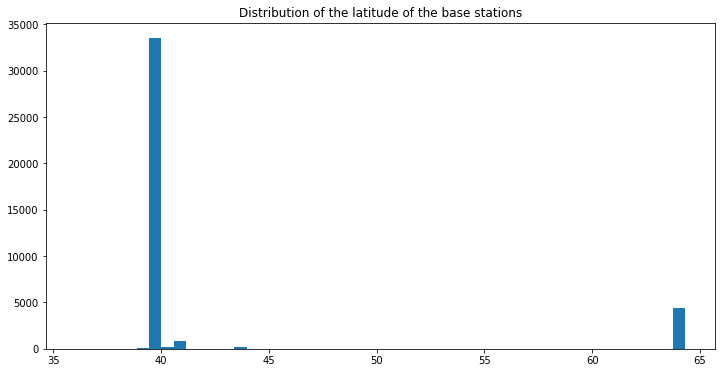

In [796]:
plt.figure(figsize=(12,6))
plt.title('Distribution of the latitude of the base stations')
plt.hist(df_mess_train['bs_lat'], bins=50)
plt.show()

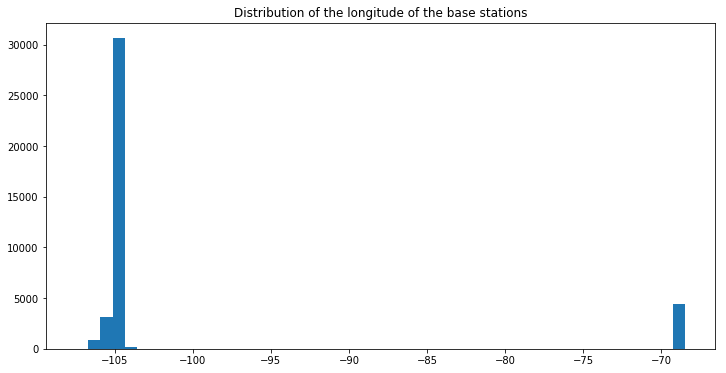

In [797]:
plt.figure(figsize=(12,6))
plt.title('Distribution of the longitude of the base stations')
plt.hist(df_mess_train['bs_lng'], bins=50)
plt.show()

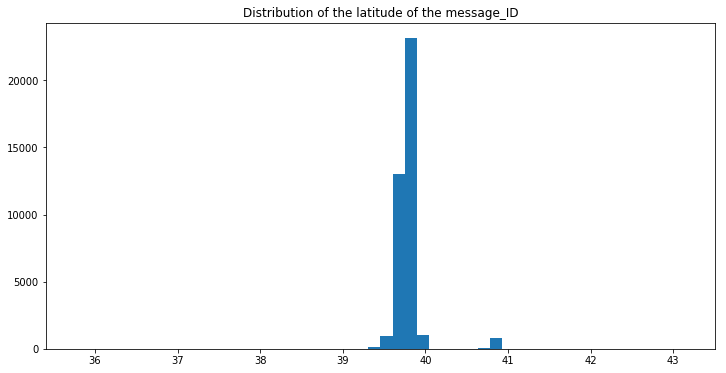

In [798]:
plt.figure(figsize=(12,6))
plt.title('Distribution of the latitude of the message_ID')
plt.hist(pos_train['lat'], bins=50)
plt.show()

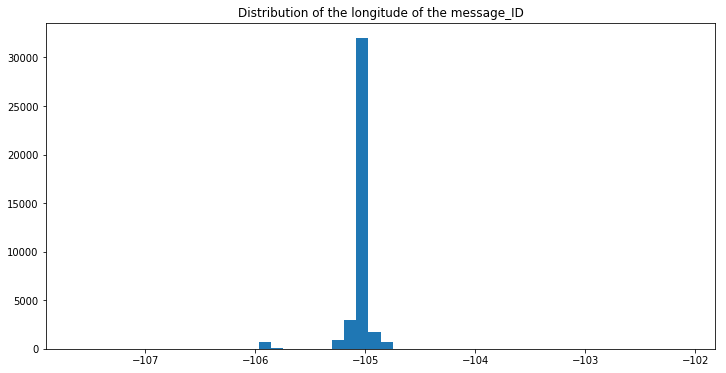

In [799]:
plt.figure(figsize=(12,6))
plt.title('Distribution of the longitude of the message_ID')
plt.hist(pos_train['lng'], bins=50)
plt.show()

Sigfox seems to have a large cover with its base stations location, but the messages measures are mostly focusing in a given area. Therefore, we should not proceed to any data cleaning in this case.

# Create the feature matrix

The aim of the feature matrix is to use the message_id as the unique key of the table. This means that we have to build several one-hot encoders in order not to loose information. 

For example, if we have 10 base stations that got the message, we need to gather the information of those 10 lines in just 1.

Actually, we need one-hot encoders for :
- the RSSI of each antenna that received the message
- the nseq of each antenna that received the message
- the longitude of each antenna that received the message
- the latitude of each antenna that received the message

We merge the train and test samples, as the number of base stations is not the same in both cases, so we need to have the same number of columns generated by the one hot encoder. We will split them again later on.

In [890]:
df = pd.concat([df_mess_train, df_mess_test]).reset_index()

In [891]:
df.shape

(68536, 9)

## Prepare several One-Hot-Encoders

In [892]:
#We give new names to the columns to avoid duplicates
one_hot = pd.get_dummies(df['bsid'])
one_hot_nseq = pd.get_dummies(df['nseq'])

one_hot_rssi = one_hot.rename(columns={x:'rssi' + str(y) for x,y in zip(one_hot.columns,range(1, len(one_hot.columns)+1))})
one_hot_distance_power = one_hot.rename(columns={x:'dist' + str(y) for x,y in zip(one_hot.columns, range(1, len(one_hot.columns)+1))})

one_hot_lat = one_hot.rename(columns={x:'lati' + str(y) for x,y in zip(one_hot.columns, range(1, len(one_hot.columns)+1))})
one_hot_lng = one_hot.rename(columns={x:'lngi' + str(y) for x,y in zip(one_hot.columns, range(1, len(one_hot.columns)+1))})

one_hot_distance_msg = one_hot.rename(columns={x:'distkm' + str(y) for x,y in zip(one_hot.columns,range(1, len(one_hot.columns)+1))})
one_hot_distance_station = one_hot.rename(columns={x:'diststation' + str(y) for x,y in zip(one_hot.columns,range(1, len(one_hot.columns)+1))})


Another varible of interest is the number of base stations that received the message. As we will later on group values by message_id, we can set this new column to 1 everywhere, and the group by with a sum will give us the number of distinct base stations that received the message.

In [893]:
df['NBAntennes'] = 1

In [894]:
# Join the encoded df
df = df.join(one_hot_rssi)

In [895]:
#Check the result df
df.head()

,index,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,NBAntennes,...,rssi250,rssi251,rssi252,rssi253,rssi254,rssi255,rssi256,rssi257,rssi258,rssi259
0,0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917,1,...,0,0,0,0,0,0,0,0,0,0
1,1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721,1,...,0,0,0,0,0,0,0,0,0,0
2,2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827,1,...,0,0,0,0,0,0,0,0,0,0
3,3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460,1,...,0,0,0,0,0,0,0,0,0,0
4,4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216,1,...,0,0,0,0,0,0,0,0,0,0


It is quite useless to store juste 0's and 1's. Instead, we will multiply the encoder on each line by the RSSI. This way, the final table will have for each base station the RSSI store on a single line. 

In [896]:
df.iloc[:,11:] = df.iloc[:,11:].multiply(df["rssi"], axis="index")

## Computing distances

### Distance between base station and message using RSSI

According to the paper "Exploiting machine learning strategies and RSSI for localization in wireless sensor networks: A survey" written in 2017 by Hanen Ahmadi and Ridha Bouallegue, the following relationship holds.

<img src='theory.png'>

In [897]:
power_up_dbm = -51.70 # Pour distance de 1km, correspond au max RSSI par approximation
lambda_onde = (2.8 * 10 ** 8)/ (868 * 10 ** 6) # onde sigfox => 868MHz
kc = 20 * np.log((4 * np.pi)/ lambda_onde)
etha = 4 #Urbain moyen

In [898]:
df['distance_to_station'] = 10**((power_up_dbm + kc - df['rssi']) / ( 10 * etha))

In [899]:
df.shape

(68536, 270)

Once again, this information should be stored in a one-hot encoder to have it on a single line when we apply the "group by".

In [900]:
df = df.join(one_hot_distance_power)

In [901]:
df.iloc[:,270:] = df.iloc[:,270:].multiply(df["distance_to_station"], axis="index")

In [902]:
df.shape

(68536, 529)

### Distance between the base station and the barycenter

Another importante distance measure is the geodesic distance, which is the minimal distance between two points on a sphere. This will be useful to measure the distance between base stations and a median barycenter point. This will allow us to identify outlying points too.

In [903]:
lat_dis = np.median(df['bs_lat'])
lng_dis = np.median(df['bs_lng'])
print(lat_dis, lng_dis)

39.7821125865 -105.044371274


In [904]:
map = folium.Map(location=[lat_dis, lng_dis], zoom_start=9.5, )
folium.CircleMarker(location = [lat_dis, lng_dis], radius=10,
                    ).add_to(map)
map.save('map-center.html')

In [905]:
%%HTML
<iframe width=100% height=550 src="map-center.html"></iframe>

In [906]:
df.head()

,index,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,NBAntennes,...,dist250,dist251,dist252,dist253,dist254,dist255,dist256,dist257,dist258,dist259
0,0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [907]:
df['distance_to_center'] = np.arccos( np.sin(np.radians(df['bs_lat'])) * np.sin(np.radians(lat_dis)) + np.cos(np.radians(df['bs_lat'])) * np.cos(np.radians(lat_dis)) * np.cos( np.radians(lng_dis - df['bs_lng'])))*6378137/1000    
df = df.join(one_hot_distance_station)
df.iloc[:,530:] = df.iloc[:,530:].multiply(df["distance_to_center"], axis="index")


In [911]:
df.head()

,index,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,NBAntennes,...,diststation250,diststation251,diststation252,diststation253,diststation254,diststation255,diststation256,diststation257,diststation258,diststation259
0,0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


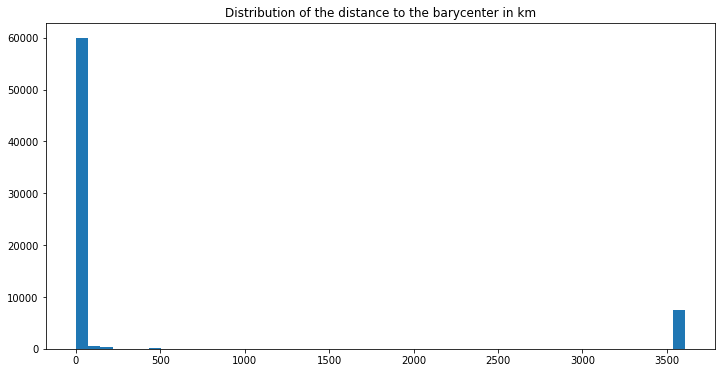

In [909]:
plt.figure(figsize=(12,6))
plt.title('Distribution of the distance to the barycenter in km')
plt.hist(df['distance_to_center'], bins=50)
plt.show()

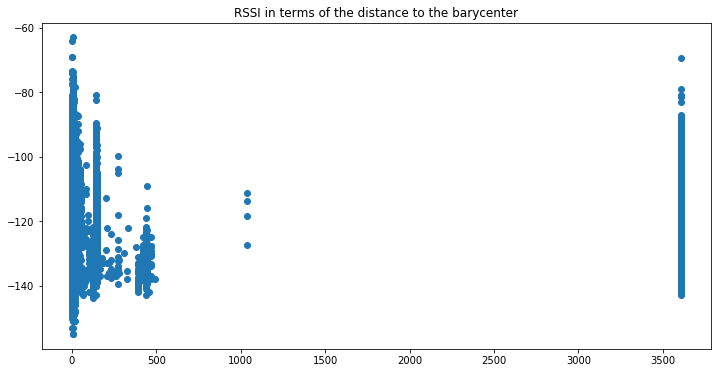

In [910]:
from scipy import stats
plt.figure(figsize=(12,6))
plt.title('RSSI in terms of the distance to the barycenter')
plt.scatter(df['distance_to_center'], df['rssi'])
plt.show()

We observe that the RSSI tends to decrease with the distance to the barycenter of the base stations.

## The nseq

First, there are some columns that are now encoded in the one hot encoder that are not needed anymore.

In [912]:
df = df.drop('rssi',axis = 1)
df = df.drop('distance_to_station',axis = 1)
df = df.drop('bsid',axis = 1)
df = df.drop('distance_to_center', axis=1)

Regarding the nseq, to the extend of our understanding : 
Everytime the Sigfox module send a message, it increments this nseq by a given value. This allows us to check if we are not loosing messages from a backend for example. 

We can encode it too, but not on the base station, but on the values that the 'nseq' takes.

In [913]:
df = df.join(one_hot_nseq)

In [914]:
df = df.drop('nseq',axis = 1)

What does our data set look like now ?

In [915]:
df.head()

,index,messid,did,time_ux,bs_lat,bs_lng,NBAntennes,rssi1,rssi2,rssi3,...,diststation255,diststation256,diststation257,diststation258,diststation259,0.0,0.5,1.0,1.5,2.0
0,0,573bf1d9864fce1a9af8c5c9,473335.0,1.463546e+12,39.617794,-104.954917,1,0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
1,1,573bf1d9864fce1a9af8c5c9,473335.0,1.463546e+12,39.677251,-104.952721,1,0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
2,2,573bf3533e952e19126b256a,473335.0,1.463547e+12,39.612745,-105.008827,1,0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0
3,3,573c0cd0f0fe6e735a699b93,473953.0,1.463553e+12,39.797969,-105.073460,1,0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
4,4,573c0cd0f0fe6e735a699b93,473953.0,1.463553e+12,39.723151,-104.956216,1,0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0


In [916]:
df.shape

(68536, 789)

We have a pretty consequent number of columns now, but we still need to add the latitude and the longitude of every base station in order not to loose this information when grouping.

## Encoding the latitude and longitude

We have already preparerd those encoders at the first step, we just need to apply the Join.

In [920]:
df = df.join(one_hot_lat)
df.iloc[:,789:] = df.iloc[:,789:].multiply(df["bs_lat"], axis="index")

In [924]:
df = df.join(one_hot_lng)
df.iloc[:,1048:] = df.iloc[:,1048:].multiply(df["bs_lng"], axis="index")

In [925]:
df.shape

(68536, 1307)

In [926]:
df = df.drop(['bs_lat', 'bs_lng', 'time_ux', 'index'], axis=1)

## Add the exact location

It is now time to concatenate the dataframe we have worked on with the exact GPS location of pos_train data set. We need to split the data sets again now.

In [927]:
df_train = df[:39250]
df_test = df[39521:]

In [928]:
df_train = pd.concat([df_train, pos_train], axis=1)

In [929]:
df_train.head()

,messid,did,NBAntennes,rssi1,rssi2,rssi3,rssi4,rssi5,rssi6,rssi7,...,lngi252,lngi253,lngi254,lngi255,lngi256,lngi257,lngi258,lngi259,lat,lng
0,573bf1d9864fce1a9af8c5c9,473335.0,1,0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,39.606690,-104.958490
1,573bf1d9864fce1a9af8c5c9,473335.0,1,0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,39.606690,-104.958490
2,573bf3533e952e19126b256a,473335.0,1,0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,39.637741,-104.958554
3,573c0cd0f0fe6e735a699b93,473953.0,1,0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,39.730417,-104.968940
4,573c0cd0f0fe6e735a699b93,473953.0,1,0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,39.730417,-104.968940


We can plot the distribution of the distance between the message geolocation and the barycenter.

In [930]:
mess = np.arccos( np.sin(np.radians(df_train['lat'])) * np.sin(np.radians(lat_dis)) + np.cos(np.radians(df_train['lat'])) * np.cos(np.radians(lat_dis)) * np.cos( np.radians(lng_dis - df_train['lng'])))*6378137/1000    


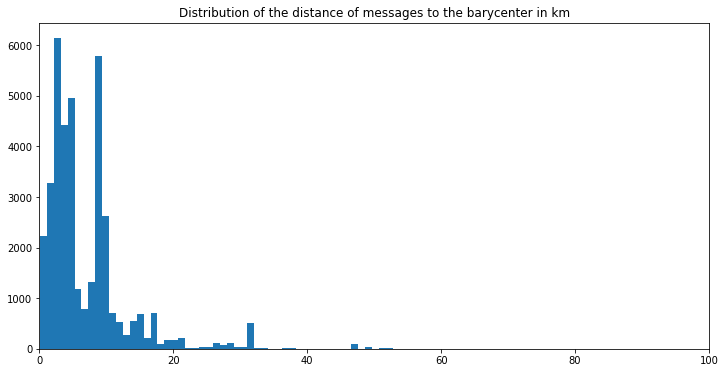

In [931]:
plt.figure(figsize=(12,6))
plt.title('Distribution of the distance of messages to the barycenter in km')
plt.hist(mess, bins=500)
plt.xlim(0,100)
plt.show()

## Group by message_id

Alright, the datas are now ready to be grouped by message_id.

In [932]:
df_train = df_train.groupby(['messid', 'did', 'lat', 'lng']).sum().reset_index()
df_train.head()

,messid,did,lat,lng,NBAntennes,rssi1,rssi2,rssi3,rssi4,rssi5,...,lngi250,lngi251,lngi252,lngi253,lngi254,lngi255,lngi256,lngi257,lngi258,lngi259
0,573bf1d9864fce1a9af8c5c9,473335.0,39.606690,-104.958490,2,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,573bf3533e952e19126b256a,473335.0,39.637741,-104.958554,1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,573c0cd0f0fe6e735a699b93,473953.0,39.730417,-104.968940,3,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,573c1272f0fe6e735a6cb8bd,476512.0,39.693102,-105.006995,4,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,573c8ea8864fce1a9a5fbf7a,476286.0,39.758167,-105.051016,42,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can move the latitude and longitude to the end of the dataframe to split it easily later on in X and y data sets.

In [933]:
cols = list(df_train.columns.values)

In [934]:
cols.pop(cols.index('lat'))
cols.pop(cols.index('lng'))
df_train = df_train[cols+['lat', 'lng']]

In [935]:
df_test = df_test.groupby(['messid', 'did']).sum().reset_index()

In [936]:
df_train.shape

(6068, 1305)

In [937]:
df_test.shape

(5248, 1303)

## Wrapping it up in a function

In [134]:
# Feature Matrix construction 
def feat_mat_const(df_train, df_test):
    
    df = pd.concat([df_mess_train, df_mess_test]).reset_index()
    
    one_hot = pd.get_dummies(df['bsid'])
    one_hot_nseq = pd.get_dummies(df['nseq'])

    one_hot_rssi = one_hot.rename(columns={x:'rssi' + str(y) for x,y in zip(one_hot.columns,range(1, len(one_hot.columns)+1))})
    one_hot_distance = one_hot.rename(columns={x:'dist' + str(y) for x,y in zip(one_hot.columns, range(1, len(one_hot.columns)+1))})

    one_hot_lat = one_hot.rename(columns={x:'lati' + str(y) for x,y in zip(one_hot.columns, range(1, len(one_hot.columns)+1))})
    one_hot_lng = one_hot.rename(columns={x:'lngi' + str(y) for x,y in zip(one_hot.columns, range(1, len(one_hot.columns)+1))})

    df['NBAntennes'] = 1

    df = df.join(one_hot_rssi)
    df.iloc[:,11:] = df.iloc[:,11:].multiply(df["rssi"], axis="index")
    
    power_up_dbm = -51.70 
    lambda_onde = (2.8 * 10 ** 8)/ (868 * 10 ** 6)
    kc = 20 * np.log((4 * np.pi)/ lambda_onde)
    etha = 4
    df['distance_to_station'] = 10**((power_up_dbm + kc - df['rssi']) / ( 10 * etha))
    df = df.join(one_hot_distance)
    df.iloc[:,263:] = df.iloc[:,263:].multiply(df["distance_to_station"], axis="index")
    
    df = df.drop('rssi',axis = 1)
    df = df.drop('distance_to_station',axis = 1)
    df = df.drop('bsid',axis = 1)
    
    df = df.join(one_hot_nseq)
    df = df.drop('nseq',axis = 1)
    
    df = df.join(one_hot_lat)
    df.iloc[:,515:] = df.iloc[:,515:].multiply(df["bs_lat"], axis="index")
    df = df.join(one_hot_lng)
    df.iloc[:,766:] = df.iloc[:,766:].multiply(df["bs_lng"], axis="index")
    
    df = df.drop(['bs_lat', 'bs_lng', 'time_ux', 'index'], axis=1)
    
    return df

In [135]:
# ground truth construction
def split_matrix(df):
    
    df_train = df[:39250]
    df_test = df[39521:]
    
    df_train = pd.concat([df_train, pos_train], axis=1)
    df_train = df_train.groupby(['messid', 'did', 'lat', 'lng']).sum().reset_index()
    
    df_test = df_test.groupby(['messid', 'did']).sum().reset_index()
    
    return df_train, df_test

Let's try our function.

In [136]:
df_train, df_test = split_matrix(feat_mat_const(df_mess_train, df_mess_test))

In [137]:
df_train.shape

(6068, 1046)

In [138]:
df_test.shape

(5248, 1044)

## Some more feature engineering

Additional features that are interesting to add include :
- overall distance : a sum of the distances to all base stations. We will also consider average, and log.
- overall RSSI : a sum of all RSSI's that near by base stations received for a given message. We will also consider the log of the sum.
- average latitude of base stations, as well as sum
- average longitude of base stations, as well as sum

In [938]:
def feature_eng(df) :
    df['sum_dist'] = np.sum(df.filter(like='dist'), axis=1)
    df['log_dist'] = np.log(df['sum_dist'])
    df['avg_dist'] = np.mean(df.filter(like='dist'), axis=1)
    
    df['sum_rssi'] = np.sum(df.filter(like='rssi'), axis=1)
    df['avg_rssi'] = np.mean(df.filter(like='rssi'), axis=1)
    
    df['avg_lat'] = np.mean(df.filter(like='lati'), axis=1)
    df['avg_lng'] = np.mean(df.filter(like='lngi'), axis=1)
    
    df['sum_lat'] = np.sum(df.filter(like='lati'), axis=1)
    df['sum_lng'] = np.sum(df.filter(like='lngi'), axis=1)
    return df

In [939]:
df_train = feature_eng(df_train)

In [940]:
cols = list(df_train.columns.values)
cols.pop(cols.index('lat'))
cols.pop(cols.index('lng'))
df_train = df_train[cols+['lat', 'lng']]

In [941]:
df_train.head()

,messid,did,NBAntennes,rssi1,rssi2,rssi3,rssi4,rssi5,rssi6,rssi7,...,log_dist,avg_dist,sum_rssi,avg_rssi,avg_lat,avg_lng,sum_lat,sum_lng,lat,lng
0,573bf1d9864fce1a9af8c5c9,473335.0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.037523,32.374743,-246.500000,-1.896154,0.306158,-0.810454,79.295045,-209.907638,39.606690,-104.958490
1,573bf3533e952e19126b256a,473335.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.956558,29.858005,-134.000000,-1.030769,0.152945,-0.405439,39.612745,-105.008827,39.637741,-104.958554
2,573c0cd0f0fe6e735a699b93,473953.0,3,0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.347443,44.131297,-352.000000,-2.707692,0.460437,-1.216229,119.253164,-315.003327,39.730417,-104.968940
3,573c1272f0fe6e735a6cb8bd,476512.0,4,0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.992848,84.132667,-509.666667,-3.920513,0.611844,-1.622093,158.467538,-420.122013,39.693102,-105.006995
4,573c8ea8864fce1a9a5fbf7a,476286.0,42,0,0.0,0.0,0.0,0.0,0.0,-141.0,...,12.381582,916.833541,-5291.833333,-40.706410,6.450627,-17.032398,1670.712328,-4411.391102,39.758167,-105.051016


In [143]:
df_test = feature_eng(df_test)

We can represent the number of base stations that received each message graphically.

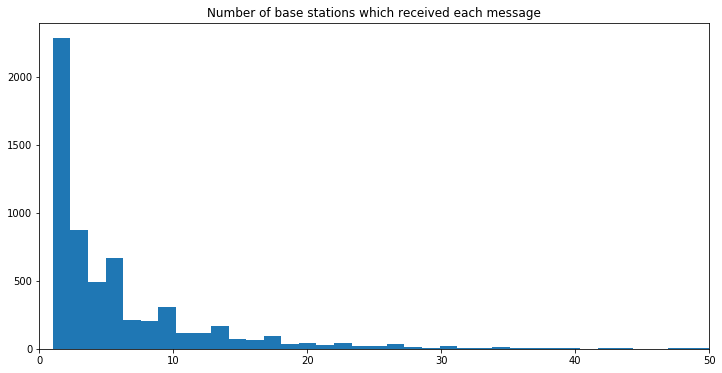

6.468358602504944

In [942]:
plt.figure(figsize=(12,6))
plt.hist(df_train['NBAntennes'], bins=80)
plt.title('Number of base stations which received each message')
plt.xlim(0, 50)
plt.show()
np.mean(df_train['NBAntennes'])

## Dimension reduction

### Principal component analysis

In [966]:
from sklearn.decomposition import PCA

pca = PCA(n_components=40)
pca_result = pca.fit_transform(df.drop(['messid'], axis=1).values)

In [967]:
print(sum(pca.explained_variance_ratio_))

0.9996409363479678


With just 40 axis in our PCA, we manage to explain more than 99.96% of the variance of the feature matrix.

## T-Distributed Stochastic Neighbouring Entities (t-SNE)

In case of high dimensional datas as we face, it is advised to apply a first dimension reduction using PCA and then a t-SNE. "t-Distributed stochastic neighbor embedding (t-SNE) minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding."

In [971]:
import time

from sklearn.manifold import TSNE
data = df.drop(['messid'], axis=1)
n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data.loc[rndperm[:n_sne]].values)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.477s...
[t-SNE] Computed neighbors for 7000 samples in 53.170s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 144.063849
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.896385
[t-SNE] Error after 300 iterations: 1.792085
t-SNE done! Time elapsed: 125.47384810447693 seconds


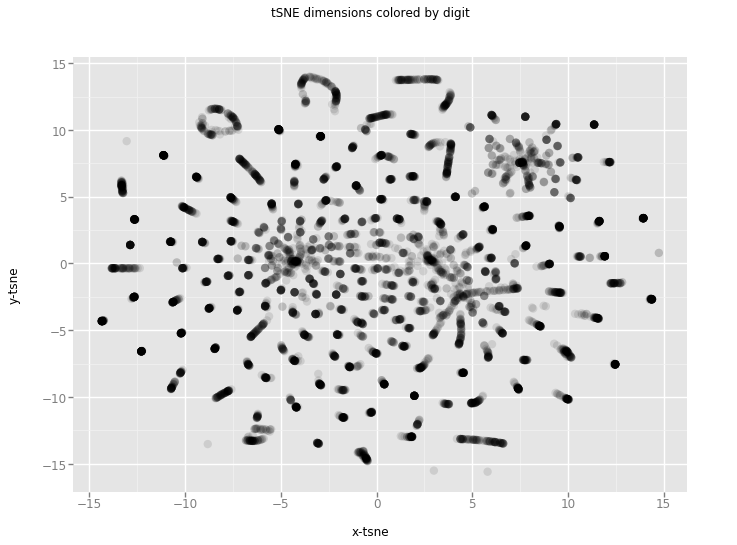

<ggplot: (-9223372029740247727)>

In [973]:
df_tsne = data.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot(df_tsne, aes(x='x-tsne', y='y-tsne') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by digit")
chart

# Train, Test, Predict

We have made the choice to predict the two outputs separately, fitting a regressor to each one.

## Create the train-test dataset

In [943]:
# ground truth construction
def ground_truth_const(df):
    
    X = df.drop(['messid'], axis=1).iloc[:,:-2]
    y_lat = df.iloc[:,-2]
    y_lng = df.iloc[:,-1]
    
    return X, y_lat, y_lng

In [944]:
X, y_lat, y_lng = ground_truth_const(df_train)

## Define Accuracy Measure

In [945]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [946]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    y_pred_lat[np.where(y_pred_lat>90)[0]]=90
    y_pred_lat[np.where(y_pred_lat<-90)[0]]=-90
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

In [947]:
from sklearn.model_selection import train_test_split
#For latitude
X_train_lat, X_test_lat, y_train_lat, y_test_lat = train_test_split(X, y_lat, test_size=0.15, random_state=44)
#For longitude
X_train_lng, X_test_lng, y_train_lng, y_test_lng = train_test_split(X, y_lng, test_size=0.15, random_state=44)

## Feature importance

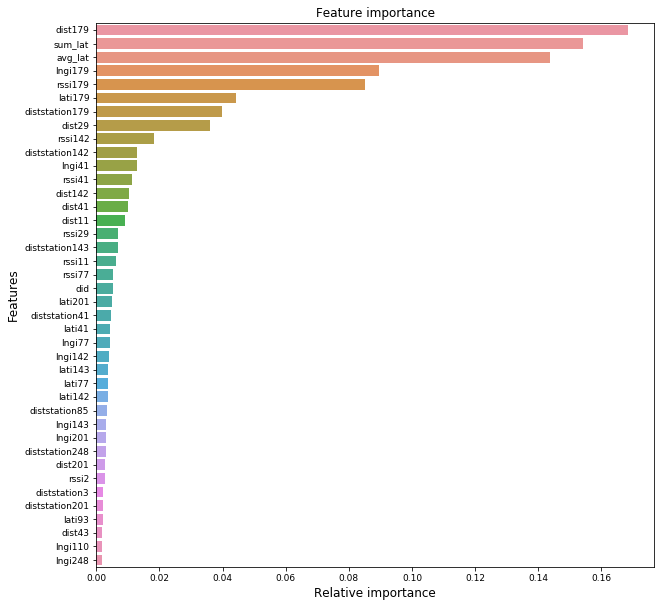

In [948]:
import seaborn as sns

plt.figure(figsize=(10,10))

name = "Random Forest"

rf = RandomForestRegressor()
rf.fit(X,y_lat)
classifier = rf

indices = np.argsort(rf.feature_importances_)[::-1][:40]
g = sns.barplot(y=X.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)

g.tick_params(labelsize=9)
g.set_title("Feature importance")
plt.savefig('impotance.png')

## K-Nearest Neighbors Regressor

In [449]:
from sklearn.neighbors import KNeighborsRegressor

### Model

In [519]:
clf_lat = KNeighborsRegressor(n_neighbors=3)
clf_lng = KNeighborsRegressor(n_neighbors=3)

In [520]:
clf_lat.fit(X_train_lat, y_train_lat)
clf_lng.fit(X_train_lng, y_train_lng)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=3, p=2,
          weights='uniform')

In [521]:
pred_lat = clf_lat.predict(X_test_lat)
pred_lng = clf_lng.predict(X_test_lng)

### Error

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


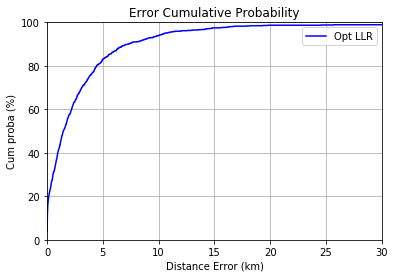

In [522]:
err_vec = Eval_geoloc(y_test_lat , y_test_lng, pred_lat, pred_lng)

values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 

plt.figure()
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
plt.show()

In [523]:
print(np.percentile(err_vec, 80))

4437.051201352491


### Hyper-parameter tuning

In [477]:
vec = []

for i in [1,2,3,4,5,6,7,8,9,10] :
    clf_lat = KNeighborsRegressor(n_neighbors = i)
    clf_lng = KNeighborsRegressor(n_neighbors = i)

    clf_lat.fit(X_train_lat, y_train_lat)
    clf_lng.fit(X_train_lng, y_train_lng)
    
    pred_lat = clf_lat.predict(X_test_lat)
    pred_lng = clf_lng.predict(X_test_lng)
    
    err_vec = Eval_geoloc(y_test_lat , y_test_lng, pred_lat, pred_lng)
    print(np.percentile(err_vec, 80))
    vec.append(np.percentile(err_vec, 80))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


4759.07865730932
4428.02443196678
4361.280660219521
4344.698332713754
4432.166924365113
4367.85761435239
4439.089080700039
4501.740115605578
4692.905509776695
4843.2787141432045


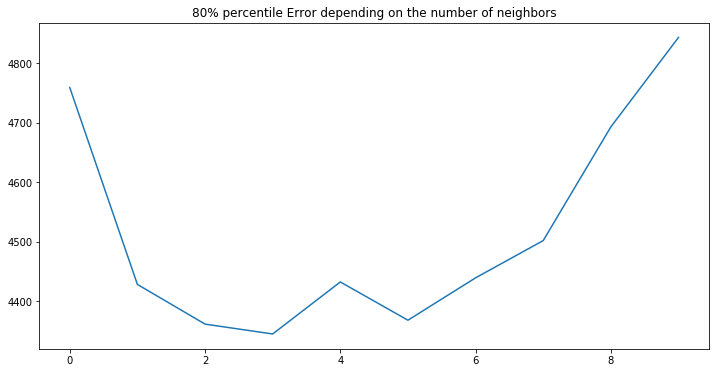

In [483]:
plt.figure(figsize=(12,6))
plt.plot(vec)
plt.title('80% percentile Error depending on the number of neighbors')
plt.show()

## Linear Model Regressor

In [179]:
from sklearn.linear_model import LinearRegression

### Model

In [180]:
clf_lat = LinearRegression()
clf_lng = LinearRegression()

In [181]:
clf_lat.fit(X_train_lat, y_train_lat)
clf_lng.fit(X_train_lng, y_train_lng)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [182]:
pred_lat = clf_lat.predict(X_test_lat)
pred_lng = clf_lng.predict(X_test_lng)

### Error

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


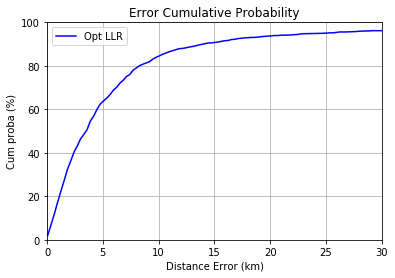

In [183]:
err_vec = Eval_geoloc(y_test_lat , y_test_lng, pred_lat, pred_lng)

values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 

plt.figure()
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
plt.show()

In [184]:
print(np.percentile(err_vec, 80))

8550.74218182005


## Support Vector Regressor

### Model

In [415]:
from sklearn.svm import SVR

In [428]:
clf_lat = SVR(C=0.01)
clf_lng = SVR(C=0.01)

In [429]:
clf_lat.fit(X_train_lat, y_train_lat)
clf_lng.fit(X_train_lng, y_train_lng)

SVR(C=0.01, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [430]:
pred_lat = clf_lat.predict(X_test_lat)
pred_lng = clf_lng.predict(X_test_lng)

### Error

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


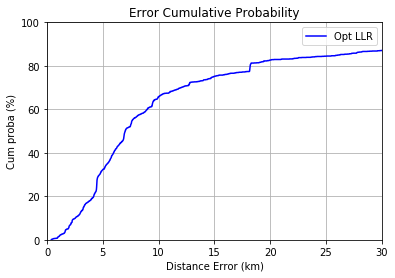

In [431]:
err_vec = Eval_geoloc(y_test_lat , y_test_lng, pred_lat, pred_lng)

values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 

plt.figure()
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend(["Opt LLR", "LLR 95", "LLR 99"])
plt.show()

In [432]:
print(np.percentile(err_vec, 80))

18207.323161334367


A support vector regressor does not seem efficient for this approach, as the result is on average 21km away from the true result, and parameter hypertuning might not be useful. 

## Decision Tree Regressor

### Model

In [30]:
from sklearn.tree import DecisionTreeRegressor

In [31]:
clf_lat = DecisionTreeRegressor()
clf_lng = DecisionTreeRegressor()

In [32]:
clf_lat.fit(X_train_lat, y_train_lat)
clf_lng.fit(X_train_lng, y_train_lng)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [33]:
pred_lat = clf_lat.predict(X_test_lat)
pred_lng = clf_lng.predict(X_test_lng)

### Error

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


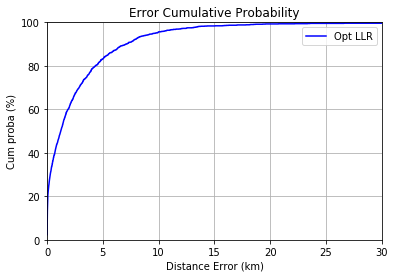

In [34]:
err_vec = Eval_geoloc(y_test_lat , y_test_lng, pred_lat, pred_lng)

values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 

plt.figure()
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
plt.show()

In [503]:
print(np.percentile(err_vec, 80))

3960.6564375493617


## Random Forest Regressor

### Model

In [949]:
from sklearn.ensemble import RandomForestRegressor

In [950]:
clf_lat = RandomForestRegressor(n_estimators = 55)
clf_lng = RandomForestRegressor(n_estimators = 55)

In [951]:
clf_lat.fit(X_train_lat, y_train_lat)
clf_lng.fit(X_train_lng, y_train_lng)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=55, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [952]:
pred_lat = clf_lat.predict(X_test_lat)
pred_lng = clf_lng.predict(X_test_lng)

### Error

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


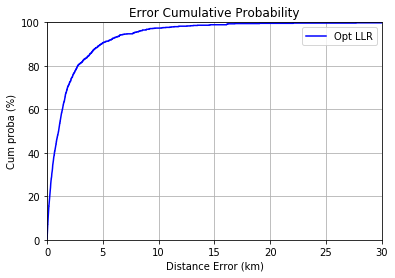

In [953]:
err_vec = Eval_geoloc(y_test_lat , y_test_lng, pred_lat, pred_lng)
#err_vec = Eval_geoloc(y_test['lat'] , y_test['lng'], pred['lat_test'], pred['lng_test'])
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 

plt.figure()
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
plt.show()

In [954]:
print(np.percentile(err_vec, 80))

2744.690918917238


### Hyper-parameter tuning

In [976]:
vec = []

for i in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100] :
    for j in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100] :
        clf_lat = RandomForestRegressor(n_estimators = i)
        clf_lng = RandomForestRegressor(n_estimators = j)

        clf_lat.fit(X_train_lat, y_train_lat)
        clf_lng.fit(X_train_lng, y_train_lng)
    
        pred_lat = clf_lat.predict(X_test_lat)
        pred_lng = clf_lng.predict(X_test_lng)
    
        err_vec = Eval_geoloc(y_test_lat , y_test_lng, pred_lat, pred_lng)
        print(np.percentile(err_vec, 80))
        vec.append(np.percentile(err_vec, 80))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3318.5475592147714


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3230.033198828411


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3214.0192337792973


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3064.1637150230376


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3260.0782640695566


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3081.410496452922


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3125.6772487332473


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3043.9682641895592


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3065.670275290136


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3106.4056574695624


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3400.410093700314


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3036.548623760466


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3153.424658994017


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3086.888354891328


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3037.9675558064537


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3184.2319266516906


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3195.238297623362


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3155.96474249908


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2959.2747491007863


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2881.645304280223


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2995.83569752436


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2901.0574671237932


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2975.111541991328


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2997.5756776993303


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2907.1913308843677


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2861.214600955037


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3067.3700144533327


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3013.5893683003414


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2803.9700897329603


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2973.6128547384533


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3056.469121308091


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2943.805197634022


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3257.896765988754


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2946.9415381093195


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2933.669251272988


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3005.442185173334


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2884.735416851196


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2811.386879566848


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2841.64478244268


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2897.072264044632


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2812.3976413770574


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2978.9859187792663


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2744.0761742486934


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2997.3417330603806


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2800.4665278610655


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2903.3727139439325


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2785.2710314805604


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2911.6391911485875


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3100.793707629838


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2918.540783708429


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3027.56484671212


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2827.6581387730157


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2892.557235052278


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2865.132237835329


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2799.54509519798


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2771.8387215012663


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3020.1071257534786


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2861.965132727809


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2830.9898318642217


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2850.1196867335384


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2791.3922226390637


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2764.7135191807656


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2868.301321908156


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2816.2989666024732


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3159.9416567941626


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2819.3562202492562


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2910.3024693476896


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2787.2958337912


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2896.5216194119316


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2802.4191865978955


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2867.1998514631937


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2894.3675047873385


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2839.991354453017


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2927.052471315034


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2834.752891069915


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2815.056951284041


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2715.051473407379


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2860.1124630305867


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2736.341679464743


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2795.356129853189


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2843.67064438546


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2906.7202073879957


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2834.3946210799845


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2927.0008255064886


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2970.1669065119195


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2817.964663529548


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2788.8574608414024


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2825.1763353894003


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2858.752613380804


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2746.2102825646484


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2736.51790574317


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2807.871727860801


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2794.574943795891


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2802.678005946398


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2709.66234500753


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2810.701928810548


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3180.1079010940707


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2910.551362916761


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2967.240108678225


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2858.389177966899


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2831.9023142537353


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2784.7018435777213


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2837.5657231684163


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2830.9873664941465


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2849.658984440846


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2895.265823936049


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2799.9965012813527


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2734.4113607744152


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2847.4118920873884


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2886.9687668189654


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2713.623798814023


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2834.2358183250717


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3094.27788137899


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2834.0631961467634


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2838.821037305205


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2915.6968142413198


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2826.195871024487


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2697.890593027089


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2748.7124718048863


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2868.5144234419895


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2790.6676297168797


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2873.5875867683085


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2788.0924816898632


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2817.7832717339243


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2839.5476101631552


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2904.479022971709


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2762.740683562394


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2833.1357058605995


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3023.50874055464


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2834.770226897183


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2777.5967209031055


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2782.371220430758


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2765.240329586959


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2756.39020294011


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2880.9343199461723


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2742.568393136205


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2824.012982387327


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2674.929010630703


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2767.1249105909783


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2822.4559040682293


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2871.3860209717254


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2702.532010855685


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2784.5214200424516


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2804.531431760296


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3026.524947478319


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2985.901311231681


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2809.010085785505


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2888.4407069819595


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2810.5669680965716


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2918.100898829124


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2728.673775023265


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2776.6371860872423


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2687.192947802284


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2795.656139074495


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2796.493348768213


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2818.9662155229503


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2867.5665679499216


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2838.565760614551


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2786.429677871211


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2762.6277160561535


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3057.598019749634


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2890.7167079099777


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2933.61396910281


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2854.628021534716


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2880.1941961635534


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2820.564395004737


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2818.836127367603


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2755.1343270281936


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2813.822920800054


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2794.16740573795


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2732.0193919181734


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2746.648806116224


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2822.3798224439047


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2833.5402554364937


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2754.0240850602136


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2781.753889002629


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3075.384351892202


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2928.2308971835396


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2847.341488234294


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2845.7938473033664


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2798.10520805663


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2806.388677464467


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2760.87886195029


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2818.9686304138368


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2776.0454882182244


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2765.380750612685


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2631.211538650794


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2806.5901948800865


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2674.971074764642


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2830.844085891532


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2669.0287888207786


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2794.5713181369274


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2970.7888630742927


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2844.9639169037705


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2890.2629184819457


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2856.0297552924567


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2799.8030024153204


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2772.9704373908294


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2838.8674395322146


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2896.0633153831545


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2833.8143059983545


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2752.086209193098


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2761.746509294087


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2679.6238433278777


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2707.034040466869


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2757.582758740872


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2801.9439284504233


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2726.4021864237693


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2977.159121909503


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2868.484349660176


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2910.82507288347


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2750.285213383503


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2801.9453940332974


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2754.869438890002


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2781.6201210195004


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2769.588817402305


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2759.763662634448


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2866.2917665013147


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2732.2634271418497


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2735.8203288400687


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2804.4818724952565


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2770.460566386435


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2802.954102102077


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2872.78023232279


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3205.0860197409725


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2961.0278989998938


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2855.7096774009624


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2948.682299279534


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2868.337068737047


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2825.2345398086336


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2853.0947239950683


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2792.6588710478245


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2742.828982122242


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2772.590948890085


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2697.7457521271353


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2859.7364639643065


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2906.9235651188483


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2866.425485020032


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2787.2530819195363


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2741.0558456046197


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3082.257045697247


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2880.067846670972


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2696.704232364102


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2837.8292088515336


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2862.570220017896


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2821.9243922541023


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2697.403553177234


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2821.595687619938


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2676.2809126457746


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2746.1631926742157


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2743.7384160950965


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2849.2191514843316


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2765.382188243415


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2743.861050806104


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


2680.336153852863
2795.031120272493


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


In [988]:
vec.index(min(vec))

186

In [989]:
ind = []

for i in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100] :
    for j in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100] :
        ind.append(str(i) + "-" + str(j))

In [990]:
ind[186]

'60-55'

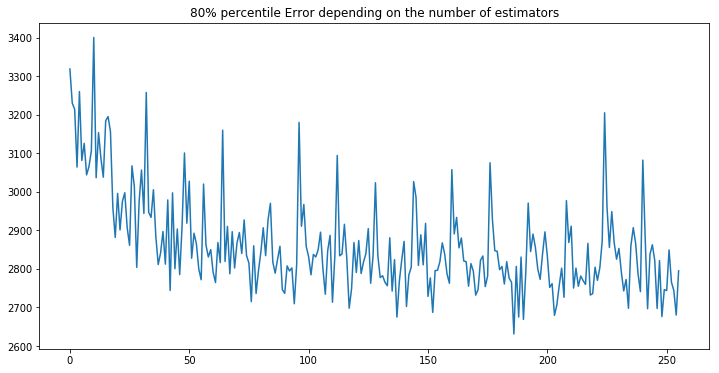

In [995]:
plt.figure(figsize=(12,6))
plt.plot(vec)
#plt.xlabel(ind) 
plt.title('80% percentile Error depending on the number of estimators')
plt.show()

## ExtraTrees Regressor

### Model

In [532]:
from sklearn.ensemble import ExtraTreesRegressor

In [533]:
clf_lat = ExtraTreesRegressor(n_estimators = 55)
clf_lng = ExtraTreesRegressor(n_estimators = 55)

In [534]:
clf_lat.fit(X_train_lat, y_train_lat)
clf_lng.fit(X_train_lng, y_train_lng)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=55, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [535]:
pred_lat = clf_lat.predict(X_test_lat)
pred_lng = clf_lng.predict(X_test_lng)

### Error

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


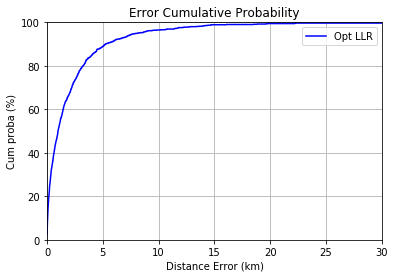

In [540]:
err_vec = Eval_geoloc(y_test_lat , y_test_lng, pred_lat, pred_lng)
#err_vec = Eval_geoloc(y_test['lat'] , y_test['lng'], pred['lat_test'], pred['lng_test'])
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 

plt.figure()
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
plt.show()

In [541]:
print(np.percentile(err_vec, 80))

3226.245345063932


### Hyper-parameter tuning

In [542]:
vec = []

for i in [20, 30, 40, 50, 60, 70, 80] :
    clf_lat = ExtraTreesRegressor(n_estimators = i)
    clf_lng = ExtraTreesRegressor(n_estimators = i)

    clf_lat.fit(X_train_lat, y_train_lat)
    clf_lng.fit(X_train_lng, y_train_lng)
    
    pred_lat = clf_lat.predict(X_test_lat)
    pred_lng = clf_lng.predict(X_test_lng)
    
    err_vec = Eval_geoloc(y_test_lat , y_test_lng, pred_lat, pred_lng)
    print(np.percentile(err_vec, 80))
    vec.append(np.percentile(err_vec, 80))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3211.134552814422


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3191.0518181003176


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3233.5631347458216


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3256.209990316286


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3209.8422782376138


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


3203.309868480794
3198.505579248496


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


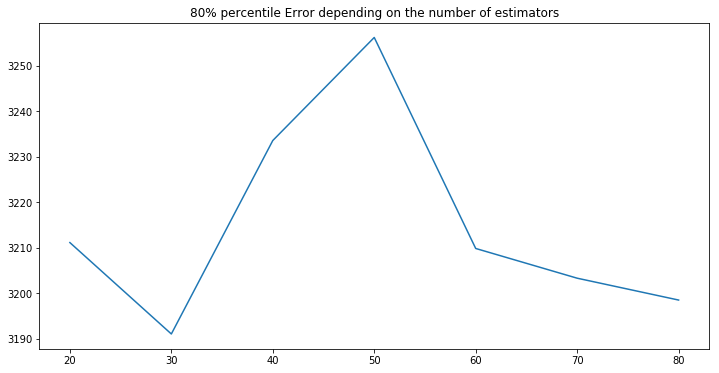

In [544]:
plt.figure(figsize=(12,6))
plt.plot([20, 30, 40, 50, 60, 70, 80], vec)
plt.title('80% percentile Error depending on the number of estimators')
plt.show()

## XGBoost

### Model

In [378]:
import xgboost

In [404]:
clf_lat = xgboost.XGBRegressor(n_estimators = 900, learning_rate = 0.05, max_depth=100)
clf_lng = xgboost.XGBRegressor(n_estimators = 900, learning_rate = 0.05, max_depth=100)
#n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7

In [405]:
clf_lat.fit(X_train_lat, y_train_lat)
clf_lng.fit(X_train_lng, y_train_lng)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=100, min_child_weight=1, missing=None, n_estimators=900,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [406]:
pred_lat = clf_lat.predict(X_test_lat)
pred_lng = clf_lng.predict(X_test_lng)

### Error

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


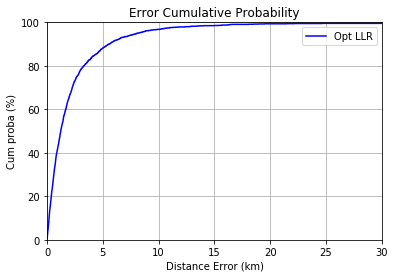

In [407]:
err_vec = Eval_geoloc(y_test_lat , y_test_lng, pred_lat, pred_lng)
#err_vec = Eval_geoloc(y_test['lat'] , y_test['lng'], pred['lat_test'], pred['lng_test'])
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 

plt.figure()
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
plt.show()

In [408]:
print(np.percentile(err_vec, 80))

3296.03698821953


## Artificial Neural Network

### Model

In [185]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [186]:
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(1052, input_dim=1052, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model

In [187]:
estimator_lat = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
estimator_lng = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)

In [188]:
estimator_lat.fit(X_train_lat, y_train_lat)
estimator_lng.fit(X_train_lng, y_train_lng)

In [189]:
pred_lat = estimator_lat.predict(X_test_lat)
pred_lng = estimator_lng.predict(X_test_lng)

### Error

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


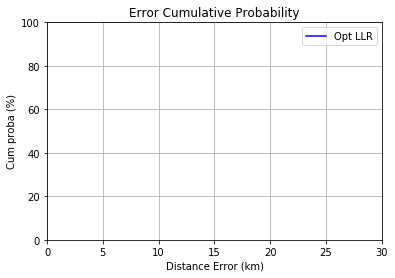

In [190]:
err_vec = Eval_geoloc(y_test_lat , y_test_lng, pred_lat, pred_lng)
#err_vec = Eval_geoloc(y_test['lat'] , y_test['lng'], pred['lat_test'], pred['lng_test'])
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 

plt.figure()
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
plt.show()

In [191]:
print(np.percentile(err_vec, 80))

4461480.555396543


## Best model selection

The best model we chose is the random forest regressor with 55 estimators. We can make a cross_val_predict in the whole dataset in order to use as much data as possible.

In [545]:
def regressor_and_predict(X, y_lat, y_lng, df_test):
    
    # train regressor and make prediction in the train set
    # Input: df_feat: feature matrix used to train regressor
    #        ground_truth_lat: df_feat associated latitude
    #        ground_truth_lng: df_feat associated longitude
    #        df_test: data frame used for prediction
    # Output: y_pred_lat, y_pred_lng

    from sklearn.model_selection import cross_val_predict
   
    clf_lat = RandomForestRegressor(n_estimators = 55)
    clf_lng = RandomForestRegressor(n_estimators = 55)
    
    pred_lng = cross_val_predict(clf_lng, X, y_lat, cv=10)
    pred_lat = cross_val_predict(clf_lat, X, y_lng, cv=10)

    return pred_lat, pred_lng

y_pred_lat, y_pred_lng = regressor_and_predict(X, y_lat, y_lng, df_test)

## Visualize output on a map

In [586]:
pred = pd.concat([pd.DataFrame(y_pred_lat), pd.DataFrame(y_pred_lng)], axis=1)
pred.columns = ['lat_pred', 'lng_pred']

In [587]:
y_test = pd.concat([pd.DataFrame(y_lat), pd.DataFrame(y_lng)], axis=1)

In [588]:
data = pd.concat([pred.reset_index(),y_test.reset_index()], axis=1)

In [589]:
data = data.drop(['index'],axis=1)

In [598]:
import pandas as pd
import folium
from matplotlib.colors import Normalize, rgb2hex
import matplotlib.cm as cm

#norm = Normalize(data['mag'].min(), data['mag'].max())

map = folium.Map(location=[39.73, -104.958490], zoom_start=10, )
for eq in data.iterrows():
    
    #color = rgb2hex(cm.OrRd(norm(float(eq[1]['mag'])))), fill_color=color, ,popup=eq[1]['place'], ,color=color, radius=4*float(eq[1]['mag']
    folium.CircleMarker(location = [eq[1]['lat'], eq[1]['lng']], radius=0.5,fill = True, fill_color='red', color='red'
                    ).add_to(map)
    folium.CircleMarker(location = [eq[1]['lng_pred'], eq[1]['lat_pred']], radius=0.5,fill = True,fill_color='blue', color='blue'
                    ).add_to(map)
    
map.save('map_pred.html')

In [599]:
%%HTML
<iframe width=100% height=500 src="map_pred.html"></iframe>

# Another Approach : Modeling dependent risks

We can observe that the data points lie among linear clusters on the map. As the data points are not random, we can use a predicted data point longitude as an additional feature to predict the latitude, and vice versa.

In [610]:
from sklearn.model_selection import train_test_split
#For latitude
X_train_lat, X_test_lat, y_train_lat, y_test_lat = train_test_split(X, y_lat, test_size=0.15, random_state=44)
#For longitude
X_train_lng, X_test_lng, y_train_lng, y_test_lng = train_test_split(X, y_lng, test_size=0.15, random_state=44)

In [611]:
clf_lat = RandomForestRegressor(n_estimators = 55)

clf_lat.fit(X_train_lat, y_train_lat)
pred_lat = clf_lat.predict(X_test_lat)

In [612]:
clf_lng = RandomForestRegressor(n_estimators = 55)

In [613]:
new_X_train = pd.concat([X_train_lat, y_train_lat], axis=1)
new_X_train.shape

(5157, 1053)

In [614]:
clf_lng.fit(new_X_train, y_train_lng)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=55, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [615]:
pred_lat = clf_lat.predict(X_test_lat)

In [616]:
new_X = pd.concat([X_test_lat.reset_index(drop=True), pd.DataFrame(pred_lat).reset_index(drop=True)], axis=1)

In [617]:
pred_lng = clf_lng.predict(new_X)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


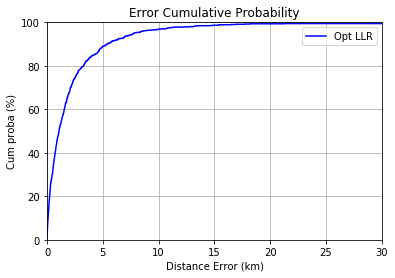

In [618]:
err_vec = Eval_geoloc(y_test_lat , y_test_lng, pred_lat, pred_lng)

values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 

plt.figure()
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
plt.show()

In [619]:
print(np.percentile(err_vec, 80))

3258.63281805939


# Prediction

In [136]:
df_train, df_test = split_matrix(feat_mat_const(df_mess_train, df_mess_test))

In [140]:
df_train = feature_eng(df_train)
df_test = feature_eng(df_test)

In [145]:
X, y_lat, y_lng = ground_truth_const(df_train)

In [143]:
y_pred_lat, y_pred_lng = regressor_and_predict(X, y_lat, y_lng, df_test)

In [29]:
test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])
test_res['messid'] = df_test['messif']

In [31]:
test_res.to_csv('pred_pos_test_list.csv', index=False)

In [32]:
test_res.head()

,lat,lng,messid
0,39.772618,-105.050029,573be2503e952e191262c351
1,39.775792,-105.063594,573c05f83e952e1912758013
2,39.678112,-105.012249,573c0796f0fe6e735a66deb3
3,39.773777,-105.037761,573c08d2864fce1a9a0563bc
4,39.678112,-105.012249,573c08ff864fce1a9a0579b0
